---

# Анализ эффективности маркетинговых компаний
### Цель проанализировать эффективность проводимых маркетинговых компаний на основании продуктовых маркетинговых метрик и метрик электронной коммерции
Изучение эффективности проводимых маркетинговых компаний на основании продуктовых маркетинговых метрик и метрик электронной коммерции <br>.
### Задачи:
1. выполнить обработку данных (выявление пропусков, их заполнение, выявление возможных причин; приведенные данных к одному формату);<br>
2. рассчитать следующие продуктовые метрики: DAU, WAU и MAU, Retention Rate<br>
3. рассчитать метрики электронной конверсии: LTV, средний чек, среднее количество покупок на покупателя, среднее время с момента первого захода на сайт до покупки товара
<br>
4. рассчитать маркетинговые метрики: общиая сумма, затраченная на маркетинг, средний CAC, ROMI по когортам в разрезе источников<br>
5. сделать общие выводы и рекомендации.

### 1. Изучим данные, проведем обработку <br>

Откроем таблицы, изменим типы данных, приведем названия столбцов к нижнему регистру и удалим пробелы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import shapiro

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={
    'device': 'device', 'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts', 'uid': 'uid'})
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={
    'buy ts': 'buy_ts', 'revenue': 'revenue', 'uid': 'uid'})
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders[orders['revenue'] == 0].count()
orders.describe()

#orders.groupby('uid')['revenue'].count().describe(percentiles=[.25, .5, .75, .83, .95, .98, .99])


,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


 
Рассмотрим подробнее столбец с оплатой: среднее значение одного чека - 2.5 у. е. 75% чеков меньше 5 у.е. - следовательно, средний чек будет тяготеть к 5. Рассмотрим, совершали ли пользователи повторные покупки - 83 % всех пользователей в таблице совершали покупки только один раз.

In [4]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()
costs['dt'] = pd.to_datetime(costs['dt'])
costs = costs.rename(columns={'source_id': 'source_id', 'dt': 'date_comp', 'costs': 'cost_comp'})
costs.describe()

,source_id,cost_comp
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


 
Проанализируем данные таблицы visits: рассчитаем время проведения на сайте, отбросим нулевые значения, посмотрим, как распределяется время, проведенное на сайте, построим гистограмму. Отбросим из данных время пребывания на сайте меньше или равно нулю. Об отрицательном времени надо спросить у программистов, вполне возможно, что это возврат билетов.

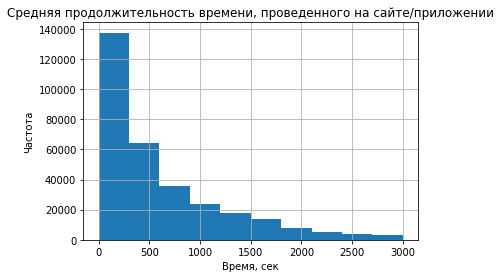

Среднее время продолжительности пребывания в приложении, сек - 60


In [5]:
visits['activity_time'] = visits['end_ts'] - visits['start_ts']
visits['activity_time'] = visits['activity_time'] / np.timedelta64(1, 's')
visits['activity_time'] = visits['activity_time'].astype('int')
activ_visits = visits[visits['activity_time'] > 0]
activ_visits.head()
activ_visits['activity_time'].hist(range=(0, 3000))
plt.title('Средняя продолжительность времени, проведенного на сайте/приложении')
plt.xlabel('Время, сек')
plt.ylabel('Частота')
plt.show()
mode = activ_visits['activity_time'].mode()
visits.describe()
print('Среднее время продолжительности пребывания в приложении, сек -',int(mode))

Как видно с графика, большинтсово пользователей проводят на сайте  до 500 сек (немного больше 8 мин). Если за это время они успевают выбрать мерояприятие и оплатить билеты - отлично!</div>



Проанализируем типы устройств, с которых пользователи заходят - это смартфоны и компьютеры. Причем с компьютеров заходят почти в три раза чаще. Что это? Недостаток мобильного приложения или офисные работники каратают рабочее время в поисках интересного? Данные гипотезы нуждаются в проверке. А пока проверим, различаются ли статистически среднее время, проведенное с компьютера, от среднего времени, проведенного со смартфона. Для этого используем метод st.ttest_ind для проверки гипотезы равенства двух средних, критерий статистической значимости alpha = 0.05. Нулевая гипотеза: среднее время, проведенное с разных типов устройств одинаковое, альтернативная - разное. Стоит отметить, что минимальное время на сайте для разных типов устройств одинаковое - 19 сек. 


Проанализируем типы устройств, с которых пользователи заходят - это смартфоны и компьютеры. Причем с компьютеров заходят почти в три раза чаще. Что это? Недостаток мобильного приложения или офисные работники каратают рабочее время в поисках интересного? Данные гипотезы нуждаются в проверке. А пока проверим, различаются ли статистически среднее время, проведенное с компьютера, от среднего времени, проведенного со смартфона.

Для проверки нормальности распределения данных используем критерий Шапиро-Уилка. Если выборки нормальны, можем применить критерий Фишера для сравнения средних значений выборок. Нулевая гипотеза: случайная величина Х в выборке распределена нормально. Альтернативная - распределение случайной величины Х не нормально. Но тест ругается, что выборка больше 5000 и данные могут быть не верными.
</div>

In [6]:
visits_device = activ_visits.groupby('device').agg({'activity_time': ['min', 'median'], 'device': 'count'}).reset_index()
visits_device.round()

desk_visits = activ_visits[activ_visits['device'] == 'desktop']['activity_time']
touch_visits = activ_visits[activ_visits['device'] == 'touch']['activity_time']

In [7]:
alpha = 0.05
stat, p = shapiro(desk_visits)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')


stat, p = shapiro(touch_visits)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Statistics=0.605, p=0.000
Отвергаем нулевую гипотезу
Statistics=0.596, p=0.000
Отвергаем нулевую гипотезу


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Значения распределены нормально, можно проверить гипотезу равенства двух средних. Для проверки гипотезы используем метод st.ttest_ind , критерий статистической значимости alpha = 0.05. Нулевая гипотеза: разница в среднем времени проведенном на сайте с компьютера и со смартфона статистически незначима, альтернативная - статистически значима. 
</div>


In [8]:
results = st.ttest_ind(desk_visits, touch_visits)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

visits_device

Отвергаем нулевую гипотезу


device activity_time         device
                     min median   count
0  desktop            19    420  238876
1    touch            19    240   84728

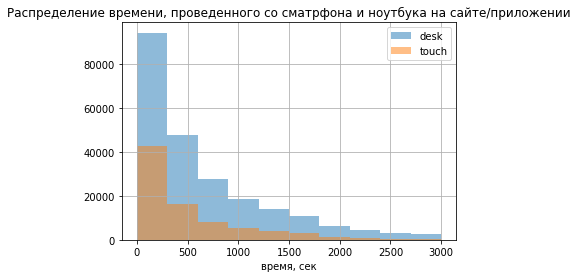

In [9]:
ax = desk_visits.hist(alpha=0.5, range=(0, 3000), label='desk')
ay = touch_visits.hist(alpha=0.5, range=(0, 3000), label='touch')
plt.title('Распределение времени, проведенного со сматрфона и ноутбука на сайте/приложении')
plt.xlabel('время, сек')
ax.legend()


На гистограмме видно, что с компьютера пользователи сайта сидят больше и охотнее остаются подольше.

### 2. Продуктовые метрики 
#### 2.1
 
Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период, отобразим изменения метрик во времени на графиках. При подсчете этих показателей я не буду учитывать пользователей, у которых время активности в приложении меньше или равно нулю. На мой взгляд, бессмысленно пририсовывать 'мертвые души' к статистике (только если мы хотим похвастаться). К тому же активность пользователя - понятие растяжимое - начиная с просмотра новостной страницы и почты, заканчивая подпиской на новости. <br>
(У меня в этой ячейке выскакивает большое красное сообщение, не знаю, что с ним делать)

In [10]:
visits['session_year'] = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')

activ_visits = visits[visits['activity_time'] > 0]

activ_visits.head()

,device,end_ts,source_id,start_ts,uid,activity_time,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-01-01,2018-02-01,2018-02-15,2018-02-19
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-01-01,2018-05-01,2018-05-17,2018-05-20
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,60,2017-01-01,2017-09-01,2017-08-31,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,3360,2018-01-01,2018-01-01,2018-01-25,2018-01-30


In [11]:
dau_total = activ_visits.groupby('session_date').agg({'uid': 'nunique'}).mean().round().astype('int')
wau_total = activ_visits.groupby('session_week').agg({'uid': 'nunique'}).mean().round().astype('int')
mau_total = activ_visits.groupby('session_month').agg({'uid': 'nunique'}).mean().round().astype('int')

sticky_wau = dau_total / wau_total * 100
sticky_mau = dau_total / mau_total * 100 

df = pd.DataFrame([['Количество уникальных пользователей в день:',int(dau_total)],
                   ['Количество уникальных пользователей в неделю:',int(wau_total)],
                   ['Количество уникальных пользователей в месяц:',int(mau_total)],
                   ['sticky factor по отношению к недельной аудитории:', float((sticky_wau).round(2))],
                   ['sticky factor по отношению к месячной аудитории:', float((sticky_mau).round(2))]
                  ])

df

,0,1
0,Количество уникальных пользователей в день:,818.00
1,Количество уникальных пользователей в неделю:,5156.00
2,Количество уникальных пользователей в месяц:,20956.00
3,sticky factor по отношению к недельной аудитории:,15.87
4,sticky factor по отношению к месячной аудитории:,3.90


 
В день наш сайт посещает в среднем чуть более 800 уникальных пользователей. Много это или мало, можно судить в сравнении с аналогичными сервисами конкурентов -  Ticketland, Ponominalu.ru., Афиша, Radario, BigBilet, Concert.ru, Intickets и Parter.ru.  <br>
Постоим графики изменения посещаемости сайтов по дням, неделям и мясецам. На графике посещения по дням видно постепенное увеличение количесвтва пользователей. Есть выраженные пики (например, в конце ноября 2017) и провалы посещаесмоти, которые нужно рассматривать отдельно. На графике недельной посещаемости есть интересные пики, которые , вероятнее всего, связаны с проведением рекламных акций. Если совместить графики недельной и месячной посещаемости, но становится очевидным, что с середины весны по сентябрь продажи и посещаемость сайта падают: это связано как с отпусками, так и с 'мертвым сезоном' в театре и кино, когда все премьеры отодвигаются на осень. Чем ближе холода и плохая погода - тем больше посетителей на сайте, готовых купить билеты.    

Text(0, 0.5, 'количество человек')

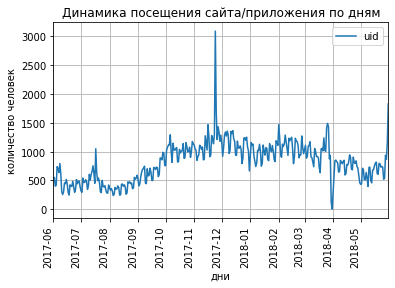

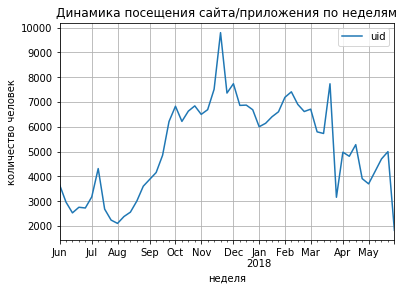

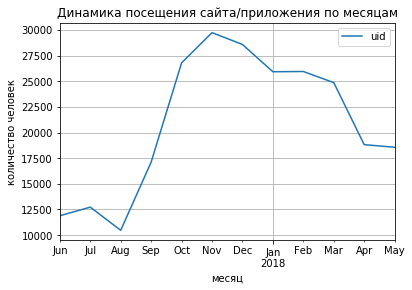

In [12]:
dau_total1 = activ_visits.groupby('session_date').agg({'uid': 'nunique'})
wau_total1 = activ_visits.groupby('session_week').agg({'uid': 'nunique'})
mau_total1 = activ_visits.groupby('session_month').agg({'uid': 'nunique'})

plt.show()
ax=dau_total1.plot(grid=True)
plt.xticks(rotation = 90)
plt.title('Динамика посещения сайта/приложения по дням')
plt.xlabel('дни')
plt.ylabel('количество человек')
plt.show

ay=wau_total1.plot(grid=True)
plt.title('Динамика посещения сайта/приложения по неделям')
plt.xlabel('неделя')
plt.ylabel('количество человек')
plt.show

az=mau_total1.plot(grid=True)
plt.title('Динамика посещения сайта/приложения по месяцам')
plt.xlabel('месяц')
plt.ylabel('количество человек')

#### 2.2
  
Рассчитаем, сколько раз за день пользователи в среднем заходят на сайт и построим график, отражающий изменения метрики во времени. В среднем, пользователи заходят на сайт один раз в день, чтобы пролистать ленту с новыми объявлениями и интересными событиями. В ночале ноября 2017 и конце января 2018 наблюдается небольшой всплеск активности.

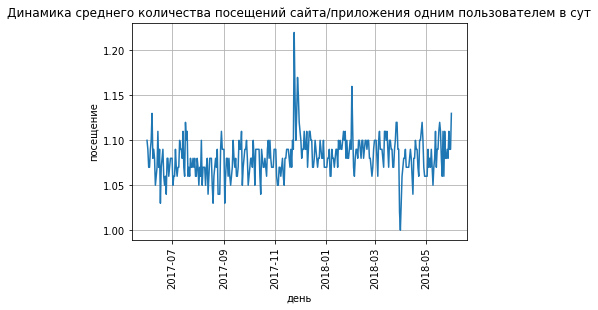

In [13]:
sessions_per_user = activ_visits.groupby(
    ['session_year', 'session_month', 'session_date'], as_index=False).agg({'uid':['count','nunique']})
sessions_per_user.rename(columns = {'count': 'n_sessions', 'nunique': 'n_users'}, inplace=True)
sessions_per_user['sess_per_user'] = (sessions_per_user[('uid', 'n_sessions')] / sessions_per_user[('uid','n_users')]).round(2)
sessions_per_user.head()

x = sessions_per_user['session_date']
y = sessions_per_user['sess_per_user']
fig, ax = plt.subplots()
ax.plot(x, y)
plt.grid()
plt.title('Динамика среднего количества посещений сайта/приложения одним пользователем в сут')
plt.xlabel('день')
plt.ylabel('посещение')
plt.xticks(rotation = 90)
plt.show()


#### 2.3
 
Рассчитаем Retention Rate, применяя когортный анализ на примере первой когорты. Найдем средний Retention Rate на второй месяц «жизни» когорт. 

In [14]:
first_activity = activ_visits.groupby(['uid'])['start_ts'].min()
first_activity.name = 'first_activity'
activ_visits = activ_visits.merge(first_activity,on='uid', how='left')
activ_visits.head()

activ_visits['visits_month'] = activ_visits['start_ts'].astype('datetime64[M]')
activ_visits['first_activity'] = activ_visits['first_activity'].astype('datetime64[M]')

activ_visits['cohort_lifetime'] = activ_visits['visits_month'] - activ_visits['first_activity']
activ_visits['cohort_lifetime'] = activ_visits['cohort_lifetime'] / np.timedelta64(1, 'M')
activ_visits['cohort_lifetime'] = activ_visits['cohort_lifetime'].round().astype('int')

cohorts = activ_visits.groupby(['first_activity','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
count_users = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity', 'uid']]
count_users = count_users.rename(columns={'uid': 'cohort_users'})
cohorts = cohorts.merge(count_users, on='first_activity')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(
    index='first_activity',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 
result = retention_pivot


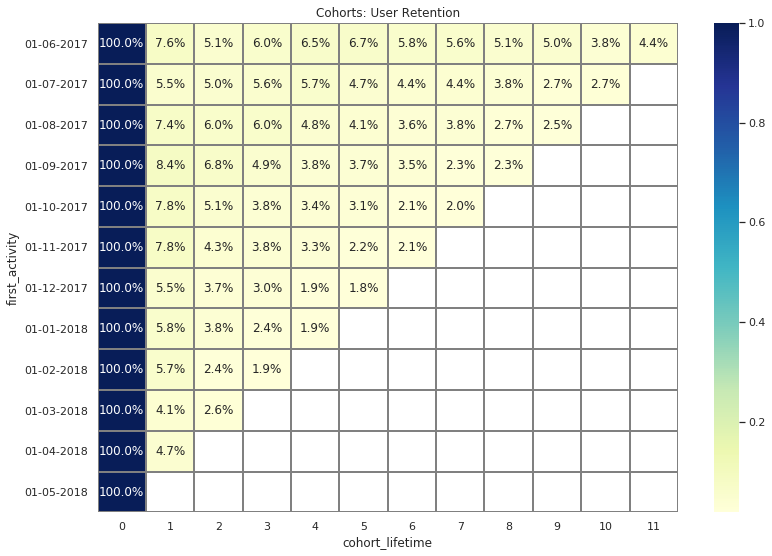

In [15]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(result, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap="YlGnBu", 
            yticklabels=result.index.strftime('%d-%m-%Y'))


Пользователи из кагорты заходят к нам из разных источников рекламы, тратят на изучение сайта до 8 мин и уходят. В следующем месяце возращается меньше 1/10 кагорты. Самой 'живучей' оказались пользователи первой когорты: к 11-му месяцу жизни их осталось 4,4 %. В остальных кагортах возврат составил 1.9 - 2.7 % на месяц последнего наблюдения. Вполне возможно, что подавляющее большинство пользователей не ходит  каждый месяц в кино/театры/музеи/др меропириятия. Они просматривают сайт, чтобы быть в курсе активных событий в городе, но покупают билеты редко. Вероятно, что все они попали на сайт, когда у них была потребность в билетах на определенное мероприятие, они потребность удовлетворили и пока не наступит новая потребность, покупать ничего не будут.
</div>

### 2. Метрики электронной коммерции
#### 2.1 Первая покупка
 
Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. За все время наблюдения пользователей впервые соверили покупку чуть более 36 тыс пользоватей. Пользователи в подавляющем большинстве сразу совершают покупку билетов. 

In [16]:
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_purchase']

df = pd.merge(first_activity, first_orders, on='uid')
df['delta_time'] = ((df['first_purchase'] - df['first_activity']) / np.timedelta64(1, 'D')).astype('int')
mode = df['delta_time'].mode()

print('В среднем проходит', int(mode),'дней с момента первого визита до первой покупки')


В среднем проходит 0 дней с момента первого визита до первой покупки


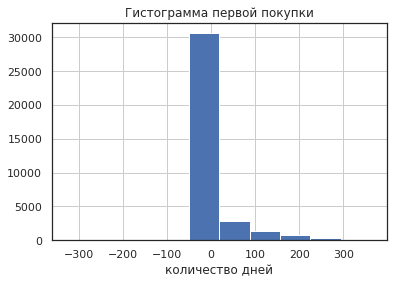

In [17]:
df['delta_time'].hist()
plt.title('Гистограмма первой покупки')
plt.xlabel('количество дней')
plt.show()

#### 2.2 LTV
 
Рассчитаем изменение LTV по кагортам

In [18]:
orders['month_pur'] = orders['buy_ts'].astype('datetime64[M]')

first_orders = orders.groupby('uid').agg({'month_pur': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [19]:
orders_new = pd.merge(first_orders, orders, on='uid')
orders_new.head()

cohorts = (
    orders_new.groupby(['first_order_month', 'month_pur'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head(30) 

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['age'] = ((report['month_pur'] - report['first_order_month']
) / np.timedelta64(1, 'M')).round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
report.head(15)

,first_order_month,n_buyers,month_pur,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531
5,2017-06-01,2023,2017-11-01,1487.92,5,0.735502
6,2017-06-01,2023,2017-12-01,1922.74,6,0.950440
7,2017-06-01,2023,2018-01-01,1176.56,7,0.581592
8,2017-06-01,2023,2018-02-01,1119.15,8,0.553213
9,2017-06-01,2023,2018-03-01,1225.51,9,0.605788


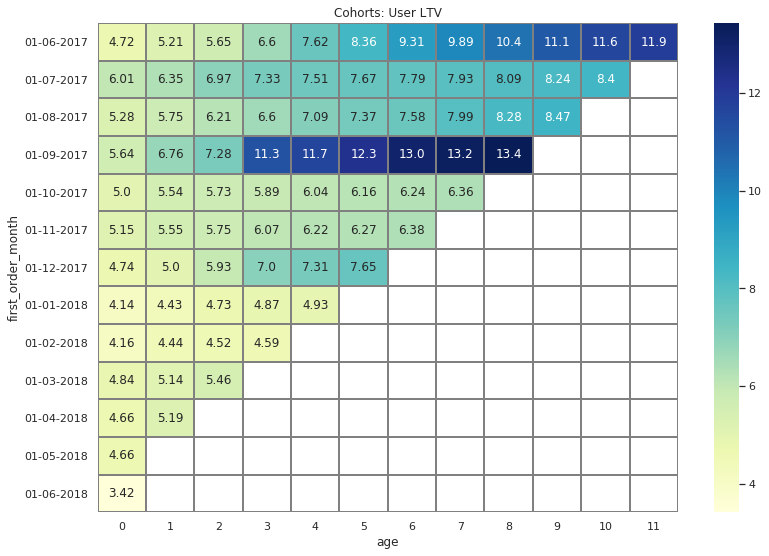

In [20]:
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
result = output.cumsum(axis=1).round(2) 
result
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User LTV')
sns.heatmap(result, annot=True, fmt='.3', linewidths=1, linecolor='gray', cmap="YlGnBu", 
            yticklabels=result.index.strftime('%d-%m-%Y'))

 Средний пользователь каждой кагорты заходит на сайт/приложение, если он готов совершить покупку, то он ее совершает в тот же день и уходит. Соответственно LTV будет фактически равно среднему чеку покупки в этой кагорте. Следовательно, тактика сайта/приложения должна заключаться в повышении среднего чека каждого пользователя при минимальных затратах на привлечение и формирование устойчивой связи у пользователя, что наш сайт/приложение самое лучшее место для повторной покупки билетов. 
  

In [21]:
ltv_201709 = report[report['first_order_month'] == '2017-09-01']
ltv_201709

,first_order_month,n_buyers,month_pur,revenue,age,ltv
33,2017-09-01,2581,2017-09-01,14568.53,0,5.644529
34,2017-09-01,2581,2017-10-01,2884.49,1,1.117586
35,2017-09-01,2581,2017-11-01,1344.52,2,0.520930
36,2017-09-01,2581,2017-12-01,10261.52,3,3.975792
37,2017-09-01,2581,2018-01-01,1033.84,4,0.400558
38,2017-09-01,2581,2018-02-01,1670.08,5,0.647067
39,2017-09-01,2581,2018-03-01,1810.85,6,0.701608
40,2017-09-01,2581,2018-04-01,627.57,7,0.243150
41,2017-09-01,2581,2018-05-01,474.92,8,0.184006


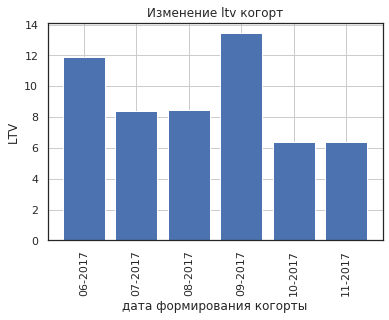

In [22]:
ltv_201706 = output.loc['2017-06-01'].sum()
ltv_201707 = output.loc['2017-07-01'].sum()
ltv_201708 = output.loc['2017-08-01'].sum()
ltv_201709 = output.loc['2017-09-01'].sum()
ltv_201710 = output.loc['2017-10-01'].sum()
ltv_201711 = output.loc['2017-11-01'].sum()

ltv_val = [ltv_201706, ltv_201707,ltv_201708, ltv_201709, ltv_201710, ltv_201711]
labels = ['06-2017', '07-2017', '08-2017', '09-2017', '10-2017', '11-2017']
fig, ax = plt.subplots()
ax.bar(labels, ltv_val)
plt.grid()
plt.xlabel('дата формирования когорты')
plt.ylabel('LTV')
plt.title('Изменение ltv когорт')
plt.xticks(rotation = 90)
plt.show()

 
На графике представлены LTV первых шести кагорт. Самые прибыльные кагорты - это кагорты, сформированные в июле и августе 2017 (возможно, пользователи покупали билеты на новый сезон в сентябре), а также ноябрьская кагорта - скорее всего, в этот месяц покупали билеты на новогодние представления в декабре.

#### 2.3 Средний чек
 
Исследуем, какой средний чек и как он меняется во времени. 

In [23]:
activ_visits1 = activ_visits.sort_values('start_ts').groupby('uid').first()
activ_visits1 = activ_visits1[['source_id', 'first_activity']]
activ_visits1 = pd.merge(activ_visits1, orders, on='uid')
activ_visits1.head()
av_check = activ_visits1.groupby('month_pur').agg({'revenue': 'sum', 'uid': 'count'}).reset_index()
av_check.columns = ['month_pur', 'sum_check', 'n_purchase']
av_check['mean_check'] = av_check['sum_check'] / av_check['n_purchase']
av_check.head()

,month_pur,sum_check,n_purchase,mean_check
0,2017-06-01,9443.50,2333,4.047793
1,2017-07-01,12485.26,2342,5.331025
2,2017-08-01,8736.44,1795,4.867097
3,2017-09-01,18232.25,3359,5.427880
4,2017-10-01,27863.56,5628,4.950881


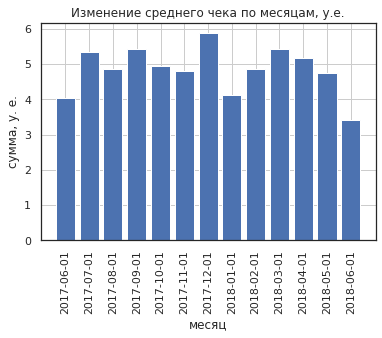

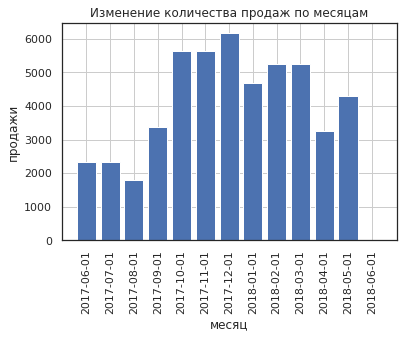

In [24]:
x = ['2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', 
     '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', 
     '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01']

y = av_check['mean_check']
y1 = av_check['n_purchase']
fig, ax = plt.subplots()
ax.bar(x, y)
plt.grid()
plt.title('Изменение среднего чека по месяцам, у.е.')
plt.xlabel('месяц')
plt.ylabel('сумма, у. е.')
plt.xticks(rotation = 90)
plt.show()

fig, ax1 = plt.subplots()
ax1.bar(x, y1)
plt.grid()
plt.title('Изменение количества продаж по месяцам')
plt.xlabel('месяц')
plt.ylabel('продажи')
plt.xticks(rotation = 90)
plt.show()

#### 2.4 Среднее количество покупок на одного покупателя

Расчитаем среднее количество покупок на одного покупателя: оно колеблется от 1 до 1.2 покупок в месяц на одного покупателя.

Text(0, 0.5, 'покупка')

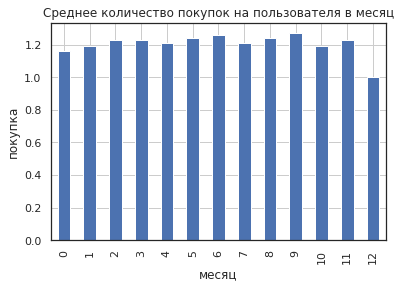

In [25]:
orders_group = orders.groupby('month_pur').agg({'uid':'nunique', 'revenue':'count'}).reset_index()
orders_group.rename(columns={'uid': 'n_buyers', 'revenue': 'n_pur'}, inplace=True)
#orders_group = pd.merge(orders_group, cohort_sizes, on='first_order_month')
orders_group['mean_pur'] = (orders_group['n_pur'] / orders_group['n_buyers']).round(2)
orders_group
orders_group['mean_pur'].plot(title='Среднее количество покупок на пользователя в месяц', grid=True, kind='bar')
plt.xlabel('месяц')
plt.ylabel('покупка')


Средний чек, как и количество покупок летом самый небольшой за год, но с наступлением осени и  увеличением событий в городе вырастает и средний чек, и количество покупок. В сентябре средний чек немного выше, чем в других осенних месяцах, хотя количество продаж меньше. Возможно это связано с более высокой стоимостью билетов на премьеры в театр. В декабре количество билетов и следом за ним средний чек резко вырастают - очевидно, что новогодние преставления и концерты пользуются большой популярностью. В январе небольшой спад в продажах, в феврале и марте снова повышаются продажи билетов (нельзя не учитывать 8 марта). В мае средний чек снова падает, хотя продажи больше, чем в апреле.

### 3. Маркетинговые метрики
#### 3.1 Общие расходы на маркетинг
  
Посчитаем общие расходы на маркетинг и расходы на каждый источник. Как видно из графика общих маркетинговых затрат, на источник 3 - М1 на втором графике - затрачено наибольшее количество денег за весь период. Это в 2.3 раза больще, чем на источник 4 - М2. В течение наблюдаемого периода затраты на рекламу постепенно уменьшались. Самые высокие затраты пришлись на самые неприбыльные летние месяца. 

Text(0, 0.5, 'затраты, у.е.')

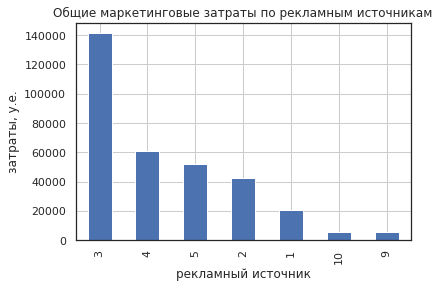

In [26]:
costs.head()
costs['date_comp'].describe()
costs['month'] = costs['date_comp'].astype('datetime64[M]')
costs_by_comp = costs.groupby('source_id')['cost_comp'].sum().sort_values(ascending=False)
costs_by_comp
ax = costs_by_comp.plot(title= 'Общие маркетинговые затраты по рекламным источникам', kind = 'bar', grid = True)
ax.set_xlabel('рекламный источник')
ax.set_ylabel('затраты, у.е.')

In [27]:
costs_by_month = costs.groupby(['source_id', 'month'])['cost_comp'].sum().sort_values(ascending=False).reset_index()
costs_by_month.head(15)
m1 = costs_by_month[costs_by_month['source_id'] == 3]['cost_comp'] 
m2 = costs_by_month[costs_by_month['source_id'] == 4]['cost_comp'] 
m3 = costs_by_month[costs_by_month['source_id'] == 5]['cost_comp']
m4 = costs_by_month[costs_by_month['source_id'] == 2]['cost_comp']
m5 = costs_by_month[costs_by_month['source_id'] == 1]['cost_comp']
m6 = costs_by_month[costs_by_month['source_id'] == 10]['cost_comp']
m7 = costs_by_month[costs_by_month['source_id'] == 9]['cost_comp']

labels = ['Juni', 'July', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

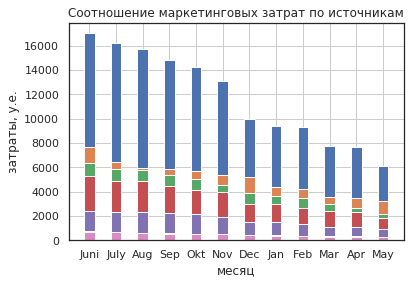

In [28]:
fig, ax = plt.subplots()
ax.bar(labels, m1, width = 0.4, label='M1')
ax.bar(labels, m2, width = 0.4, label='M2')
ax.bar(labels, m3, width = 0.4, label='M3')
ax.bar(labels, m4, width = 0.4, label='M4')
ax.bar(labels, m5, width = 0.4, label='M5')
ax.bar(labels, m6, width = 0.4, label='M6')
ax.bar(labels, m7, width = 0.4, label='M7')
plt.title('Соотношение маркетинговых затрат по источникам')
plt.xlabel('месяц')
plt.ylabel('затраты, у.е.')
plt.grid()



В разрезе по месяцам наблюдается постепенное уменьшение затрат на маркетинг: с 16 тыс дл 6 т. Если сопоставить  общее количество продаж по месяцам и затрат на маркетинг, то наибольшие затраты на маркетинг пришлись на летние месяцы с самыми низкими продажами. Хорошо бы проверить, вырастут ли продажи, если начать показывать больше рекламы в осенние месяцы.

#### 3.2 Стоимость привлечения одного пользователя на сайт
 
Посчитаем, сколько денег требуется на привлечение одного клиента, который в последующем станет покупателем и построим график по источнкам рекламы.


In [29]:
buyers = pd.merge(first_orders, activ_visits, on='uid')
buyers_daily = buyers.groupby(['source_id', 'first_activity']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily.head()

costs_group = costs.groupby(['source_id', 'month'])['cost_comp'].sum().reset_index()
costs_ = pd.merge(buyers_daily, costs_group, left_on=['source_id', 'first_activity'], right_on=['source_id', 'month'])
costs_['costs_per_buyer'] = costs_['cost_comp'] / costs_['n_buyers']
#costs_[costs_['source_id'] == 3]

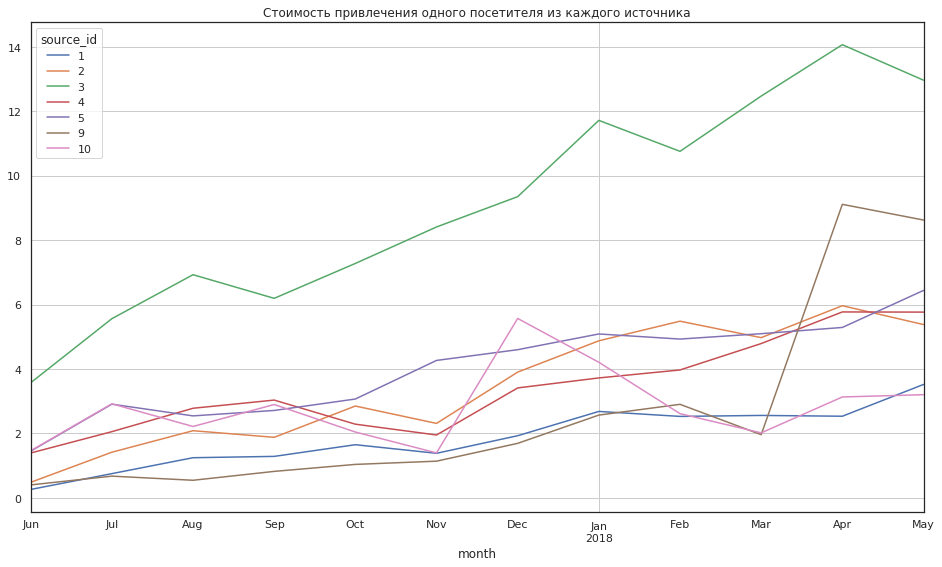

In [30]:
costs_.pivot_table(index=['month'], 
    columns='source_id', values='costs_per_buyer', aggfunc='mean').plot(figsize=(16,9),
    title='Стоимость привлечения одного посетителя из каждого источника', grid=True)
plt.show()


На графике видно, что хоть наши затраты на маркетинг в течение года снижались, но при этом стоимость пользователя росла. Причин может быть множество: и более активная реклама конкурентов, и смена формата рекламы, который не понравился пользователем, а возможно, что рекламу сначала тестировали в регионах, а затем перключились на более крупные города, где цена клика выше. Надо идти к маркетологам и спрашивать, как в динамике менялась наша реклама, реклама конкурентов. Дороже всего пользователь, привлеченыый с помощью источника 3: за год он вырос с 4 у е до 13. А стоит вспомнить, что наш средний чек 2.5 у е (при 100 % маржинальности) и покупают у нас только один раз. Не удивительно, что у нас расход на маркетинг больше, чем доход. 

#### 3.3 САС, ROMI

Посчитаем CAC и ROMI по кагортам


In [31]:
costs_by_month1 = costs.groupby(['month'])['cost_comp'].sum().reset_index()
costs_by_month1.rename(columns={'month': 'month_pur'}, inplace=True)

report_new = pd.merge(report, costs_by_month1, left_on='first_order_month', right_on='month_pur')

report_new['cac'] = (report_new['cost_comp'] / report_new['n_buyers']).round(2)
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new
output1 = report_new.pivot_table(
index='first_order_month', columns='age', values='romi', aggfunc='mean')
result = output1.cumsum(axis=1).round(2)



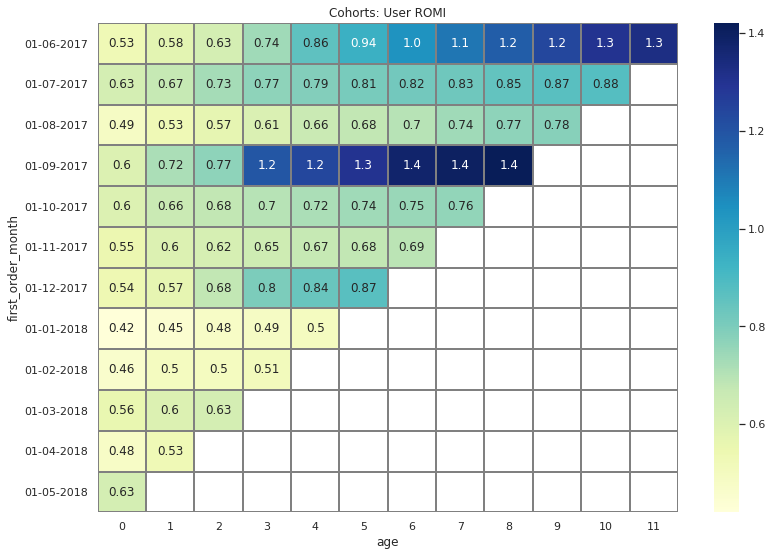

In [32]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User ROMI')
sns.heatmap(result, annot=True, fmt='.2', linewidths=1, linecolor='gray', cmap="YlGnBu", 
            yticklabels=result.index.strftime('%d-%m-%Y'))
plt.show() 

#### CAC
 
Вывод: затраты на привлечение клиента по кагортам за год калеблются, в среднем, от 7.5 ло 11 у е/пользователь. Самая дорогая кагорта - кагорта, сформированная в августе 2017 - почти 11 у е. С учетом того, что кагорты не окупились, нужно  повышать средний чек и снижать стоимость привлечения клиента на сервис.

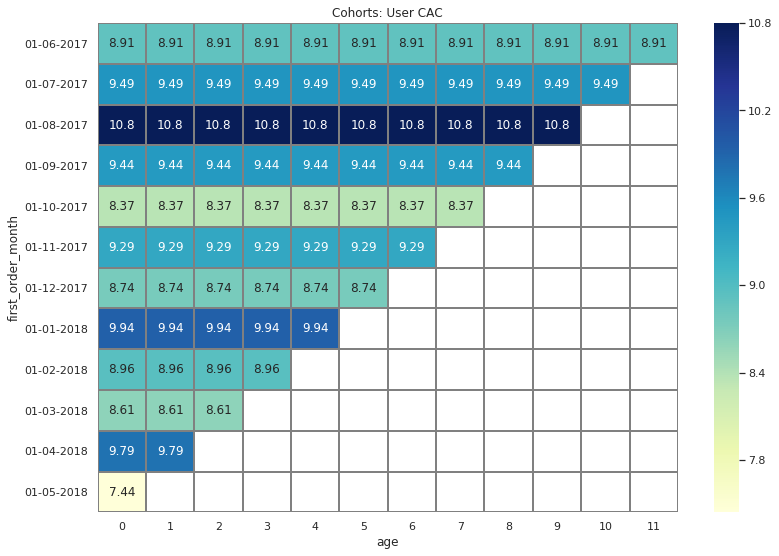

In [33]:
output1 = report_new.pivot_table(
index='first_order_month', columns='age', values='cac', aggfunc='mean')
output1
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User САС')
sns.heatmap(output1, annot=True, fmt='.3', linewidths=1, linecolor='gray', cmap="YlGnBu", 
            yticklabels=result.index.strftime('%d-%m-%Y'))
plt.show() 

In [34]:
sum = orders['revenue'].sum()
sum

252057.19999999998

In [35]:
sum1 = costs['cost_comp'].sum()
sum1

329131.62


Из 12 когорт окупились только 2: первая и сентябрьская (и то благодаря большим покупкам на третий месяц жизни кагорты). А если посмотреть суммарные расходы на маркетинг и найти общую стоимость клиента, то на маркетинг мы потратили больше, чем получили прибыли. Привлечение одного клиента нам обошлось дороже, чем он нам принес. Врядли руководство компании оценит наши старания) В следующих месяцах нужно заработать сверху 77 тыс, чтобы отбить этот неудачный год.   

#### 3.1ROMI

Посчитаем, сколько человек пришло и совершило покупку с каждого источника рекламы. Половина всех пользователей пришло с 4 и 3 источников рекламы. Почти еще половина - с 1, 2 и 5 источников, около 6 % - с 9 и 10. 

In [36]:
activ_visits1 = activ_visits.sort_values('start_ts').groupby('uid').first()
activ_visits1 = activ_visits1[['source_id']].reset_index()
activ_visits1
orders = pd.merge(orders, activ_visits1, on='uid')
orders = pd.merge(orders, first_orders, on='uid')
orders['age'] = ((orders['month_pur'] - orders['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
orders.head()

,buy_ts,revenue,uid,month_pur,source_id,first_order_month,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,2017-06-01,0


In [37]:
list_=[1, 2, 3, 4, 5, 9, 10]
buyers = []
for i in list_:
    data = orders[orders['source_id'] == i]
    buyers.append(len(data))
    #return buyers
print(buyers)
marketing_byuers = zip(list_, buyers)
marketing_byuers = pd.DataFrame(marketing_byuers, columns=['source_id', 'n_byuers']) 
marketing_byuers['part_byuers'] = (((marketing_byuers['n_byuers'] / marketing_byuers['n_byuers'].sum())) * 100).round(2)
marketing_byuers
    

[5102, 6425, 12999, 12695, 9512, 1652, 1555]


,source_id,n_byuers,part_byuers
0,1,5102,10.22
1,2,6425,12.87
2,3,12999,26.03
3,4,12695,25.42
4,5,9512,19.05
5,9,1652,3.31
6,10,1555,3.11


 
Оценим, сколько в среднем пришло пользователей с каждого источника рекламы, сколько принесли дохода и сколько стоил пользователь. Для этого рассчитаем romi по формуле: (прибыль-расходы)/ расходы х 100 %. Таким образом мы дадим оценку эффективности рекламы по каждому источнику за год. <br>
Как видно из таблицы, источники  4, 10 и 3, на который ушла почти половина рекламного бюджета, является самым неэффективным источником рекламы, котоый приносит весьма ощутимые убытки. Самый эффетивный источник рекламы - 1, за ним следует 2, источники 5 и 9 принесли наименшую прибыль(ну хоть не убытки).

In [38]:
orders_gr = orders.groupby('source_id')['revenue'].sum().reset_index()
orders_gr['part_sale'] = ((orders_gr['revenue'] / orders_gr['revenue'].sum()) * 100).round(2)
marketing_byuers = pd.merge(marketing_byuers, orders_gr, on='source_id')
                            
costs_gr = costs.groupby('source_id')['cost_comp'].sum().reset_index()
marketing_byuers = pd.merge(marketing_byuers, costs_gr, on='source_id')
marketing_byuers['cost_byuer_men'] = (marketing_byuers['cost_comp'] / marketing_byuers['n_byuers']).round(2)
marketing_byuers['income_uid'] = (marketing_byuers['revenue'] / marketing_byuers['n_byuers']).round(2)
marketing_byuers['romi'] = ((marketing_byuers['income_uid'] - marketing_byuers['cost_byuer_men']) / marketing_byuers['cost_byuer_men'] * 100).round(2)
marketing_byuers

,source_id,n_byuers,part_byuers,revenue,part_sale,cost_comp,cost_byuer_men,income_uid,romi
0,1,5102,10.22,30537.37,12.21,20833.27,4.08,5.99,46.81
1,2,6425,12.87,47265.19,18.89,42806.04,6.66,7.36,10.51
2,3,12999,26.03,53061.62,21.21,141321.63,10.87,4.08,-62.47
3,4,12695,25.42,55601.15,22.22,61073.60,4.81,4.38,-8.94
4,5,9512,19.05,53352.23,21.33,51757.10,5.44,5.61,3.12
5,9,1652,3.31,5746.85,2.30,5517.49,3.34,3.48,4.19
6,10,1555,3.11,4611.73,1.84,5822.49,3.74,2.97,-20.59


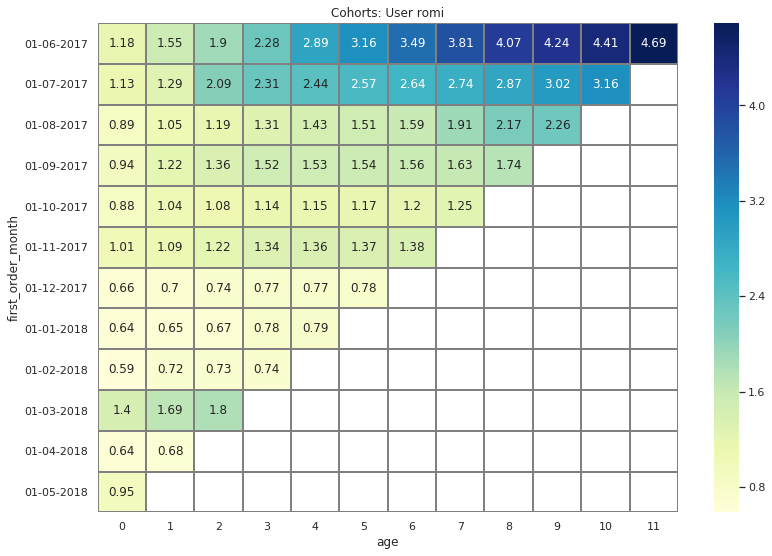

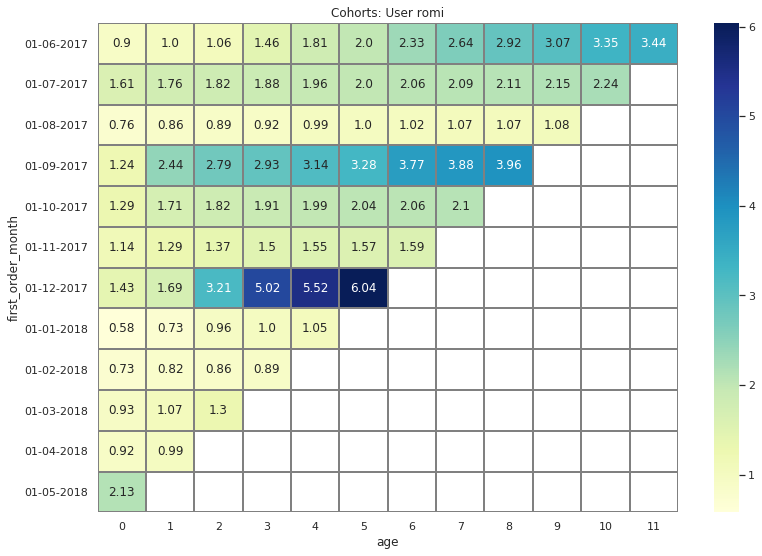

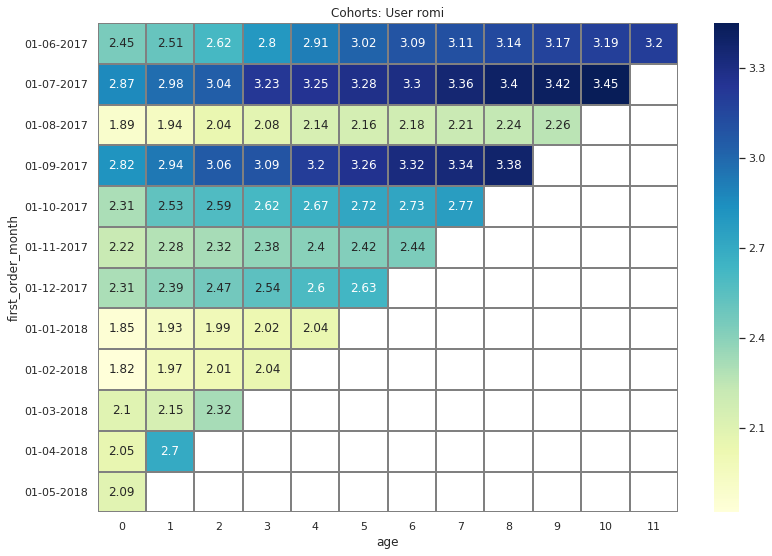

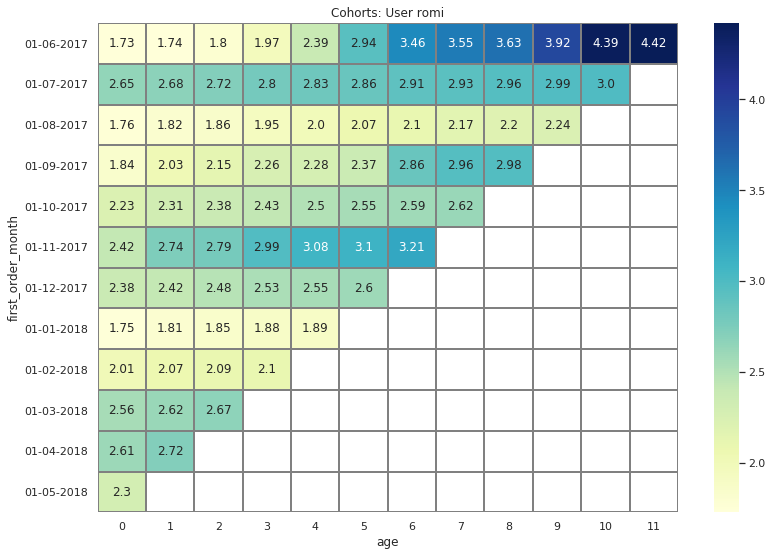

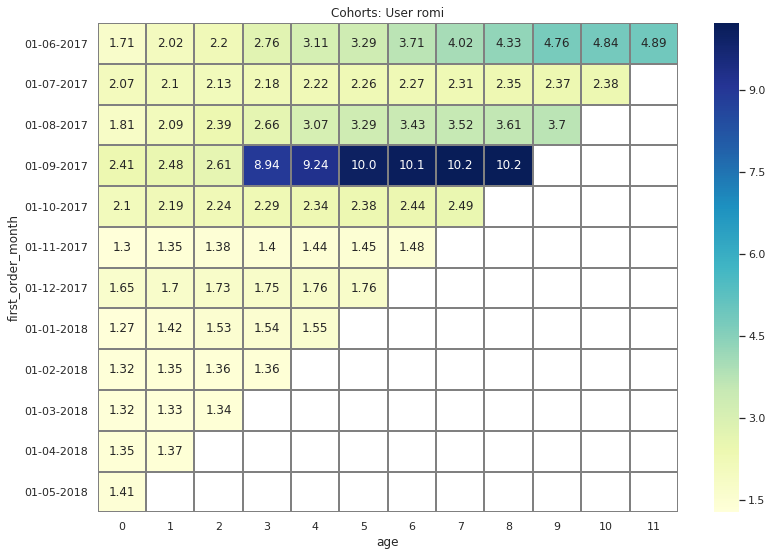

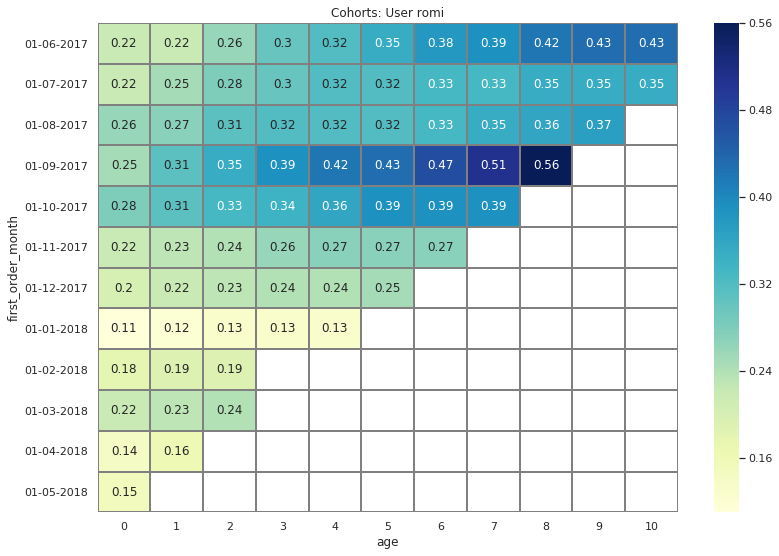

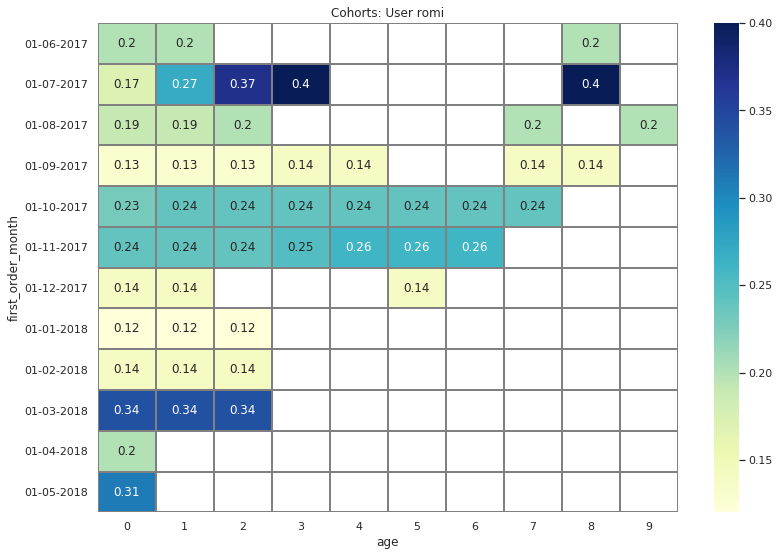

In [39]:
list_=[1, 2, 3, 4, 5, 9, 10]
for i in list_:
    data = orders[orders['source_id'] == i]
    cohort_sizes = data.groupby(['first_order_month']).agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    cohorts = data.groupby(['first_order_month', 'month_pur']).agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    report['age'] = ((report['month_pur'] - report['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
    report['ltv'] = report['revenue'] / report['n_buyers']
    output2 = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
    costs_i = costs[costs['source_id'] == 1]
    costs_gr = costs_i.groupby('month')['cost_comp'].sum().reset_index()
    report = pd.merge(report, costs_gr, left_on='first_order_month', right_on='month')
    report['cac'] = report['cost_comp'] / report['n_buyers']
    report['romi'] = report['ltv'] / report['cac']
    output2 = report.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean').round(2)
    result = output2.cumsum(axis=1).round(2)
    #print('marceting',i, output2.cumsum(axis=1).round(2))
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: User romi')
    sns.heatmap(result, annot=True, fmt='.3', linewidths=1, linecolor='gray', cmap="YlGnBu",
               yticklabels=result.index.strftime('%d-%m-%Y'))


Если оценить источники рекламы в разрезе когорт, то можно заметить, что чтобы реклама окупилась, первая же когорта должна полностью (или на 80 %) окупиться и принести прибыль. Если этого не произойдет в месяц формирования кагорты, то мы выйдем в убытки, так как процент возврата маленький.   
С этой точки зрения 9 и 10 источники рекламы самые худшие, так как они не окупаются. 1 источник рекламы показал неплохие результаты на первых 6 когортах и мартовской кагорте 2018 , остальные кагорты не окупились. Второй и третий источники маркетинга показали лучшие результаты в соотношении цена привлечения клиента-прибыль. В пятом источнике самой прибыльной оказалась сентябрьская кагорта, пользователи которой совершили крупные покупки. 

### 4. Выводы
#### 4.1 Общие выводы
  
1. В день на сайт заходит в среднем чуть более 800 уникальных пользователей, в неделю – более 5000, в месяц – почти 21 000. В июне-августе посещаемость сайта/приложения более низкая, чем в сентябре-декабре. В сентябре-декабре возрастает количество продаж на сайте. Средний чек не сильно зависит от времени года. Retention Rate довольно низкий – 2-4 %. <br>
2. Средний пользователь каждой кагорты заходит на сайт/приложение, если он готов совершить покупку, то он ее совершает в тот же день и уходит. Соответственно LTV будет фактически равно среднему чеку покупки в этой кагорте. Следовательно, тактика сайта/приложения должна заключаться в повышении среднего чека каждого пользователя при минимальных затратах на привлечение и формирование устойчивой связи у пользователя, что наш сайт/приложение самое лучшее место для повторной покупки билетов.   <br>
3. В течение наблюдаемого периода затраты на маркетинг уменьшаются со 160 тыс у е до 6 тыс у е в месяц. При этом средняя стоимость привлечения одного клиента за год растет. Больше всего за год выросла стоимость привлечения клиента с источника № 3: с 4 до 15 у е. Самые высокие затраты пришлись на источник рекламы №3 – около 140 тыс за год. Из всех когорт за год окупилась только две кагорты: первая и сентябрьская. То есть привлечение одного клиента обошлось нам дороже, чем он принес нам клиент. <br>
4. Больше всего – около половины - человек пришло и совершило покупку с 3 и 4 источников рекламы. Почти еще половина - с 1, 2 и 5 источников, около 6 % - с 9 и 10. <br>
   